In [1]:
%run ../cube/Cube.ipynb

import numpy as np
import random
import time
from numba import njit

Support algs imported!
Cube initiated


In [2]:
move_list = np.array(['R', 'R2', 'R\'', 'L', 'L2', 'L\'', 'r', 'r2', 'r\'', 'l', 'l2', 'l\'', 'M', 'M2', 'M\'', 'U', 'U2', 'U\'', 'D', 'D2', 'D\'', 'u', 'u2', 'u\'', 'd', 'd2', 'd\'', 'E', 'E2', 'E\'', 'F', 'F2', 'F\'', 'B', 'B2', 'B\'', 'f', 'f2', 'f\'', 'b', 'b2', 'b\'', 'S', 'S2', 'S\''])
move_to_id = {move: i for i, move in enumerate(move_list)}
id_to_move = {i: move for i, move in enumerate(move_list)}

@njit
def array_to_alg(array):
    # no -1s as moves
    return " ".join([move_list[id] for id in array if id != -1])

# @njit
def alg_to_array(alg):
    return np.array([move_to_id[move] for move in alg.split()])

# function to invert an alg
@njit
def invert_alg_array(alg_array):
    inv_array = alg_array[::-1]
    inv_array = np.concatenate((inv_array[inv_array!=-1], 3*inv_array[inv_array==-1]))
    return inv_array + 2*(1-inv_array%3)

# run once to compile
print(invert_alg_array(np.array([0, -1, -1, -1])))
print(array_to_alg(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11, 12, 13, 14, 15, 16, 17,32])))
print(alg_to_array("R U R' U' R' U' F R f' R' U R S"))

[ 2 -1 -1 -1]
R R2 R' L L2 L' r r2 r' l l2 l' M M2 M' U U2 U' F'
[ 0 15  2 17  2 17 30  0 38  2 15  0 42]


In [3]:
@njit
def cancel_alg_array(alg_array): 
    # cancels an alg array
    changes = True
    pointer = -1
    while changes:
        changes = False
        alg_array = np.concatenate((alg_array[alg_array != -1], alg_array[alg_array == -1]))

        for i in range(len(alg_array)-1):
            if alg_array[i] == -1:
                pointer = i
                break # we can stop here because we know that the rest of the array is -1
            if alg_array[i] == -2:
                alg_array[i] = -1 # we don't need to track this change because it is not a move
                changes = True
                continue
            if alg_array[i]//3 == alg_array[i+1]//3:
                # if it cancels fully, the new move is -2 (which we need to change to -1 later)
                # if it cancels partially, the current move is set to -1 and the next move is changed to the new move

                base_move = alg_array[i]//3*3
                total_rotation = (2 + alg_array[i]%3 + alg_array[i+1]%3)%4-1
                alg_array[i] = -1
                if total_rotation >= 0:
                    alg_array[i+1] = base_move + total_rotation
                else:
                    alg_array[i+1] = -2
                changes = True
        if alg_array[-1] == -2:
            alg_array[-1] = -1

    return alg_array[:pointer]

@njit
def cancel_alg_arrays(alg_array1, alg_array2):
    alg_array = np.concatenate((alg_array1, alg_array2, np.array([-1])))
    return cancel_alg_array(alg_array)

alg1, alg2 = np.array([ 2,8,14]), np.array([6, 2, 3])
cancel_alg_arrays(alg1, alg2)

array([ 2,  8, 14,  6,  2,  3], dtype=int64)

In [4]:
# Get move_to_grip from grip_move_tables.py
%run grip_move_tables.py

# estimate the exponential growth of the number of algs using this table
# it's dependent on the number of non-zero elements in the table, but also on the "chance" we are in a certain state

# 1. count the number of non-zero elements in each row
non_zero_elements = np.sum(move_to_grip != 0, axis=1)[1:]
# 2. count the number of 0s, 1s, ... in the table
elements_count = np.bincount(move_to_grip.flatten())[1:]
# 3. convert to probability
elements_prob = elements_count / np.sum(elements_count)
# 4. estimate the exponential growth
exp_growth = np.sum(non_zero_elements * elements_prob)
print("Exponential Growth:",round(exp_growth,3))
n = 9
print(f"Estimated #algs at length {n}:",f"{int(exp_growth**n):,}")

Exponential Growth: 9.957
Estimated #algs at length 9: 961,543,235


In [5]:
@njit
def is_regripless(move_array, start_grips = np.array([1, 2, 3]), move_to_grip = move_to_grip):
    # check if the alg is regripless
    grips = start_grips
    for move in move_array:
        grips = move_to_grip[grips, move]
        # print(grips, move, move_list[move])
        if np.all(grips == 0):
            return False
    return True

alg_array = alg_to_array("R U' R2 D' r U2 r' D R2 U R'")
start_grips = np.array([1])
is_regripless(alg_array, start_grips)

False

In [6]:
@njit
def get_valid_moves(grip, last_move):
    init_moves = np.where(move_to_grip[grip])[0]
    return init_moves[init_moves//3 != last_move//3] # remove moves that are in the same axis as the last move

# same as above, but for a list of grips
@njit
def get_valid_moves_list(grips, last_move):
    possible_moves = np.zeros(45, dtype=np.int64)
    for grip in grips:
        possible_moves += move_to_grip[grip]
    viable_moves = np.where(possible_moves)[0]

    return viable_moves[viable_moves//3 != last_move//3]

@njit
def check_rlr(alg_array):
    # ex: R, L, l, r, M
    # max 2 moves from these in a row, and only in one direction (R L is fine, L R is not)
    # we check this in two steps: first we check if there are more than 2 moves from the same grip in a row

    if len(alg_array) < 2:
        return True
    
    for i in range(len(alg_array)-2):
        if alg_array[i]//15 == alg_array[i+1]//15 == alg_array[i+2]//15:
            return False
    
    for i in range(len(alg_array)-1):
        if alg_array[i]//15 == alg_array[i+1]//15 and (alg_array[i]<alg_array[i+1] or alg_array[i]%15>11 or alg_array[i+1]%15>11): # if same axis, force 1, and also make sure none of the moves are slice moves as they are covered by wide moves
            return False
        # # check for "slice moves" resulted by R r' or something similar.
        # if alg_array[i]//15 == alg_array[i+1]//15 and (alg_array[i]%15 - alg_array[i+1]%15):
        #     return False
    return True

@njit
def check_rlr2(alg_array):
    # same as above, but assumes the array has length 3, so we don't need to check that nor loop
    if alg_array[0]//15 == alg_array[1]//15 == alg_array[2]//15:
        return False

    if alg_array[1]//15 == alg_array[2]//15 and (alg_array[1]<alg_array[2] or alg_array[2]%15>11): # if same axis, force 1, and also make sure last move is not slice move as that is covered by wide moves. No need to check second last move is that is checked before in the function above
        return False
    return True

In [9]:
@njit
def gen_algs(length, start_grips = np.array([1,2,3]), move_to_grip = move_to_grip):

    algs = np.zeros((1000+14**length, length), dtype = np.int8) # we need to exceed the exponential factor
    i = 0 # keep track of the number of algs we have

    current_grip = np.zeros((length+1, len(start_grips)), dtype = np.int8) # first grip is the start grip
    current_grip[0] = start_grips # this will stay unchanged
    current_alg = -np.ones(length+1, dtype = np.int8)
    current_alg[0] = -1 # not a possible move, so we can start at 0

    pointer = 1 # start pointing at the first move (we use this for both algs and grips)

    while pointer > 0:
        # criterion for adding algs: pointer == length
        if pointer == length:
            # if the alg has rlr without the first move, we don't need to check all the other moves
            if check_rlr(current_alg[1:-1]):
                # loop though and add the alg to the array if the last move doesn't regrip
                valid_moves = get_valid_moves_list(current_grip[pointer-1], current_alg[pointer-1])
                # print(valid_moves)
                for move in valid_moves:
                    current_alg[pointer] = move
                    if check_rlr2(current_alg[-3:]): # check if the last two moves are rlr
                        algs[i] = current_alg[1:]
                        i += 1
            # then we go back one step (instead of setting current_alg[pointer] to 45 and dealing with it next cycle)
            current_alg[pointer] = -1
            pointer -= 1
            continue

        # if we haven't gone back, we increment the current move, set the next grip, and increment the pointer
        current_alg[pointer] += 1
        # make sure the move is valid: 1) it's a valid move, 2) it's not on the same face as the previous move, and 3) it's a regripless move
        while True: #current_alg[pointer] < 45 and current_alg[pointer]//3 == current_alg[pointer-1]//3 and move_to_grip[current_grip[pointer-1], current_alg[pointer]] != 0:
            if current_alg[pointer] == 45:
                break
            if current_alg[pointer]//3 != current_alg[pointer-1]//3 and (move_to_grip[current_grip[pointer-1], current_alg[pointer]]).any() != 0:
                break
            current_alg[pointer] += 1
        # criterion for going back: current_alg[pointer] == 45
        if current_alg[pointer] == 45:
            current_alg[pointer] = -1
            pointer -= 1
            continue
        
        # update the grip
        for j in range(len(start_grips)):
            current_grip[pointer, j] = move_to_grip[current_grip[pointer-1, j], current_alg[pointer]]
        pointer += 1
    
    return algs[:i]

# run once to compile
N = 5
start_grips = np.array([1])
algs = gen_algs(N, start_grips)
len(algs)

42860

True

In [10]:
def gen_algs_cumulative(max_length, start_grips = [1], min_length = 1): #TODO add more start-grips. Also make list unique after
    # generates algs of length min_length to max_length
    algs = []
    t = time.time()
    for i in range(min_length, max_length+1):
        new_algs = gen_algs(i, start_grips)
        # pad with max_length - i -1s
        new_algs = np.pad(new_algs, ((0,0),(0,max_length-i)), constant_values = -1)
        algs.append(new_algs)
        print(f"Algs of length {i} genned. Time spent: {time.time()-t:.2f}s")

    print(f"Done genning algs. Making into np array. Time spent: {time.time()-t:.2f}s")
    algs = np.concatenate(algs)

    return algs

N = 8
start_grips = (np.array(range(len(move_to_grip)))+1)[:-1]
algs = gen_algs_cumulative(N, start_grips)
len(algs)

Algs of length 1 genned. Time spent: 0.00s
Algs of length 2 genned. Time spent: 0.00s
Algs of length 3 genned. Time spent: 0.00s
Algs of length 4 genned. Time spent: 0.01s
Algs of length 5 genned. Time spent: 0.04s
Algs of length 6 genned. Time spent: 0.31s
Algs of length 7 genned. Time spent: 2.28s
Algs of length 8 genned. Time spent: 20.52s
Done genning algs. Making into np array. Time spent: 20.52s


85697733

In [11]:
for i in range(10):
    print(array_to_alg(algs[random.randint(0, len(algs))]))

r' R' U' f F' R f F
f D2 F' R U' R
f U R U R' D R2 D
U' r F D' U2 S' r'
U' F' R f' F l' U L
R S r' F' D2 F' R2 U2
f' R' D' F U2 R S' F'
f' D2 F' r' U2 r S D
D l f R U2 r' U
F' R' U' F D U2 f' U2


In [12]:
def gen_table(algs): # Idea: Can we use np arrays instead so we can njit this? Another idea to make it less memory intensive is to append indexes to the table instead of the algs themselves. This should not affect the speed that much as the lookup is O(1) anyway
    # we won't bother creating a Cube object, we will just use the array-based alg
    table = {}
    t = time.time()
    print(f"Genning table based on {len(algs)} algs")
    cubestate = np.array([0,0,0,1,1,1,1,1,1,0,0,0,2,2,2,2,2,2,0,0,0,3,3,3,3,3,3,0,0,0,4,4,4,4,4,4,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5]) # LL removed
    for i, alg in enumerate(algs):
        if i and i%(len(algs)//100) == 0:
            print(f"{i} ({i/len(algs)*100:.2f}%) algs added in {time.time()-t:.2f} seconds")
        cubestate = _apply_int_moves(cubestate, invert_alg_array(alg))
        ID = id_from_state(cubestate)
        if ID not in table:
            table[ID] = [alg]
        else:
            table[ID].append(alg)
        cubestate = _apply_int_moves(cubestate, alg)
    
    return table

table = gen_table(algs)
len(table)

Genning table based on 85697733 algs
856977 (1.00%) algs added in 11.29 seconds
1713954 (2.00%) algs added in 21.04 seconds
2570931 (3.00%) algs added in 31.13 seconds
3427908 (4.00%) algs added in 41.79 seconds
4284885 (5.00%) algs added in 52.32 seconds
5141862 (6.00%) algs added in 62.61 seconds
5998839 (7.00%) algs added in 72.29 seconds
6855816 (8.00%) algs added in 82.34 seconds
7712793 (9.00%) algs added in 91.97 seconds
8569770 (10.00%) algs added in 102.67 seconds
9426747 (11.00%) algs added in 112.70 seconds
10283724 (12.00%) algs added in 123.36 seconds
11140701 (13.00%) algs added in 133.84 seconds
11997678 (14.00%) algs added in 143.82 seconds
12854655 (15.00%) algs added in 154.89 seconds
13711632 (16.00%) algs added in 164.73 seconds
14568609 (17.00%) algs added in 174.92 seconds
15425586 (18.00%) algs added in 185.06 seconds
16282563 (19.00%) algs added in 196.12 seconds
17139540 (20.00%) algs added in 206.64 seconds
17996517 (21.00%) algs added in 217.41 seconds
188534

52885792

In [14]:
# make custom bridge

# S R' U' R U R S'
bridge_array = np.array([30, 2, 8, 0, 6, 0, 32])

# cube = Cube()
# cube.apply_int_moves(bridge_array)
# cube.plot()

bridge_array = np.array([-1]) # no bridge

In [61]:
def gen_LL_algs(algs, table):
    # we won't bother creating a Cube object, we will just use the cubestate array
    LL_algs = []
    t = time.time()
    print(f"Genning LL algs based on {len(algs)} algs")

    cubestate = np.array([0,0,0,1,1,1,1,1,1,0,0,0,2,2,2,2,2,2,0,0,0,3,3,3,3,3,3,0,0,0,4,4,4,4,4,4,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5]) # LL removed
    for i, setup in enumerate(algs):
        if i and i%(len(algs)//100) == 0:
            # make it unique
            LL_algs = list(set(tuple(map(tuple, LL_algs))))
            print(f"{i} ({i/len(algs)*100:.2f}%) setups checked in {time.time()-t:.2f} seconds. {len(LL_algs)} LL algs found")
            
        # we don't want to start nor stop with a U as that's redundant. We have to check for D starts in case D in the end isnt fingertrickable
        if setup[0]//3 == 5:
            continue
        setup = cancel_alg_arrays(setup, bridge_array)
        cubestate = _apply_int_moves(cubestate, setup)

        # cubestate = _change_state(cubestate,alg_dict["KP"]) # apply kåre parity, or some other alg if wanted

        ID = id_from_state(cubestate)
        if ID in table:
            # if KP or similar, we use E2 as a placeholder. NOTE: this does not change the cube representation, it just changes the alg
            # setup = np.concatenate((setup, np.array([34])))
            for finish in table[ID]:
                alg = cancel_alg_arrays(setup, finish)

                if len(alg) == 0:
                    continue
                if alg[0]//3 == 5 or alg[-1]//3 == 5: # we don't want to end with U
                    continue
                if alg[0]//3 == 6 and alg[-1]//3 == 6: # if we start and end with D*, we remove it as we only need to do it once
                    continue
                # print(array_to_alg(setup),"-", array_to_alg(finish),"-", array_to_alg(alg))
                # print(setup, finish, alg)
                if check_rlr(alg):
                    LL_algs.append(alg)
            # if KP or similar, we remove the E2 placeholder as we have to undo the setup
            # setup = setup[:-1]
        
        # cubestate = _change_state(cubestate,alg_dict["KP'"]) # undo kåre parity, or some other alg if wanted

        cubestate = _apply_int_moves(cubestate, invert_alg_array(setup))
    
    LL_algs = list(set(tuple(map(tuple, LL_algs))))
    return LL_algs

start_grips = np.array([1,10])
algs = gen_algs_cumulative(8, start_grips)
LL_algs = gen_LL_algs(algs, table)
print(len(LL_algs))

Algs of length 1 genned. Time spent: 0.00s
Algs of length 2 genned. Time spent: 0.00s
Algs of length 3 genned. Time spent: 0.00s
Algs of length 4 genned. Time spent: 0.00s
Algs of length 5 genned. Time spent: 0.02s
Algs of length 6 genned. Time spent: 0.15s
Algs of length 7 genned. Time spent: 1.15s
Algs of length 8 genned. Time spent: 12.74s
Done genning algs. Making into np array. Time spent: 12.74s
Genning LL algs based on 26623675 algs
266236 (1.00%) setups checked in 11.67 seconds. 93823 LL algs found
532472 (2.00%) setups checked in 22.33 seconds. 156530 LL algs found
798708 (3.00%) setups checked in 34.29 seconds. 225667 LL algs found
1064944 (4.00%) setups checked in 44.68 seconds. 255661 LL algs found
1331180 (5.00%) setups checked in 53.33 seconds. 272854 LL algs found
1597416 (6.00%) setups checked in 59.76 seconds. 292641 LL algs found
1863652 (7.00%) setups checked in 60.48 seconds. 292641 LL algs found
2129888 (8.00%) setups checked in 61.19 seconds. 292641 LL algs found


In [30]:
# sort algorithm
#   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44],
#   [R,R2,R', L,L2,L', r,r2,r', l,l2,l', M,M2,M', U,U2,U', D,D2,D', u,u2,u', d,d2,d', E,E2,E', F,F2,F', B,B2,B', f,f2,f', b,b2,b', S,S2,S'],
@njit
def score_alg(alg):
    # gives a score based on the number of moves, then the moves themselves
    score = 4*len(alg)**0.5
    for move in alg:
        score += (move%3==1) # add 1 if the move is a 180 degree turn
        score += 2*(move%15 > 5) # add 1 if the move is wide or slice
        score += 2*(move%15 <= 5) and (move//15 == 2) # add 1 if the move is F/B
        score += 2*(3<=move<=5) # add 1 if the move is L
        score += 2*(18<=move<=20) # add 1 if the move is D
    return score

# sort by length
LL_algs = sorted(LL_algs, key = lambda x: score_alg(x))
# LL_algs_str = [array_to_alg(alg) for alg in LL_algs]
# for i,alg in enumerate(LL_algs_str):
#     print(f"{i+1}: {alg}")

In [62]:
# make a dict of the algs
# for each alg, apply the inverse to the solved state
# then we check if the state is in the dict for all 4 AUFs
# if it's not, we add it to the dict
# if it is, we add the alg to the list of algs for that state

@njit
def check_OLL_solved(cubestate):
    for i in [36,37,38,39,41,42]:
        if cubestate[i] != 5:
            return False
    return True

@njit
def check_ZBLL(cubestate):
    for i in [37,39,41]:
        if cubestate[i] != 5:
            return False
    return True

def gen_LL_algs_dict(LL_algs, no_regrips = True, start_grips = np.array([1,2,3])):
    # LL_algs: list of LL algs
    # no_regrips: if True, only gen algs that don't regrip
    # start_grip: the grip to start with, only applies if no_regrips is True
    LL_algs_dict = {}
    t = time.time()
    
    idsLL = np.array([0,1,2,9,10,11,18,19,20,27,28,29,37,39,41,43])
    for i, alg in enumerate(LL_algs):
        if i and i%(len(LL_algs)//100) == 0:
            print(f"{i} ({i/len(LL_algs)*100:.2f}%) algs added in {time.time()-t:.2f} seconds.")

        if alg[-1]//3 == 5: # we don't want to end with U
            continue
        cubestate = np.array([1]*9+[2]*9+[3]*9+[4]*9+[5]*9+[6]*9) #normal mode
        # cubestate = np.array([0,0,0,1,1,1,1,1,1,0,0,0,2,2,2,2,2,2,0,0,0,3,3,3,3,3,3,0,0,0,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6]) # PLL removed, gens only OLL
        alg = np.array(alg)
        inv = invert_alg_array(alg)
        cubestate = _apply_int_moves(cubestate, alg)
        # # check that OLL is solved (for getting only PLLs)
        # if not check_OLL_solved(cubestate):
        #     continue
        # check if ZBLL
        if not check_ZBLL(cubestate):
            continue

        cubestate = _apply_int_moves(cubestate, inv)
        # check for no regrips
        if no_regrips and not is_regripless(alg, start_grips):
            continue

        KP = False
        if 34 in alg:
            setup = alg[:np.where(alg==34)[0][0]]
            finish = alg[np.where(alg==34)[0][0]+1:]
            KP = True

        # check if any aufs match
        flag = False
        for u1 in [15,16,17,-1]:
            for u2 in [15,16,17,-1]:
                cubestate = _apply_int_moves(cubestate, np.array([u1]))
                if KP:
                    cubestate = _apply_int_moves(cubestate, invert_alg_array(finish))
                    cubestate = _change_state(cubestate,alg_dict["KP'"])
                    cubestate = _apply_int_moves(cubestate, invert_alg_array(setup))
                else:
                    cubestate = _apply_int_moves(cubestate, inv)
                cubestate = _apply_int_moves(cubestate, np.array([u2]))
                ID = id_from_state(cubestate, idsLL)
                if ID in LL_algs_dict:
                    LL_algs_dict[ID].append(alg)
                    flag = True
                    break
                cubestate = _apply_int_moves(cubestate, invert_alg_array(np.array([u2])))
                if KP:
                    cubestate = _apply_int_moves(cubestate, setup)
                    cubestate = _change_state(cubestate,alg_dict["KP"])
                    cubestate = _apply_int_moves(cubestate, finish)
                else:
                    cubestate = _apply_int_moves(cubestate, alg)
                cubestate = _apply_int_moves(cubestate, invert_alg_array(np.array([u1])))
            if flag:
                break
        if not flag:
            LL_algs_dict[ID] = [alg]

    return LL_algs_dict

LL_algs_dict = gen_LL_algs_dict(LL_algs, True, np.array([1]))
len(LL_algs_dict)

17604 (1.00%) algs added in 0.78 seconds.
35208 (2.00%) algs added in 1.15 seconds.
52812 (3.00%) algs added in 1.59 seconds.
70416 (4.00%) algs added in 2.08 seconds.
88020 (5.00%) algs added in 2.48 seconds.
105624 (6.00%) algs added in 2.94 seconds.
123228 (7.00%) algs added in 3.40 seconds.
140832 (8.00%) algs added in 3.78 seconds.
158436 (9.00%) algs added in 4.21 seconds.
176040 (10.00%) algs added in 4.69 seconds.
193644 (11.00%) algs added in 5.15 seconds.
211248 (12.00%) algs added in 5.65 seconds.
228852 (13.00%) algs added in 6.11 seconds.
246456 (14.00%) algs added in 6.49 seconds.
264060 (15.00%) algs added in 6.97 seconds.
281664 (16.00%) algs added in 7.38 seconds.
299268 (17.00%) algs added in 7.84 seconds.
316872 (18.00%) algs added in 8.29 seconds.
334476 (19.00%) algs added in 8.72 seconds.
352080 (20.00%) algs added in 9.20 seconds.
369684 (21.00%) algs added in 9.63 seconds.
387288 (22.00%) algs added in 10.06 seconds.
404892 (23.00%) algs added in 10.43 seconds.


492

In [63]:
import matplotlib.patches as patches

def plot_top_layer(cubestate, colors=["grey","green","r","b","darkorange","w","y"]):
    # plot the top layer of a cube and the layer around it
    # cubestate: np array of length 54
    top = [36,37,38,39,40,41,42,43,44]
    around = [0,1,2,9,10,11,18,19,20,27,28,29]

    top_x = [-1,0,1,-1,0,1,-1,0,1]
    top_y = [1,1,1,0,0,0,-1,-1,-1]
    around_x = [-1,0,1,2,2,2,1,0,-1,-2,-2,-2]
    around_y = [-2,-2,-2,-1,0,1,2,2,2,1,0,-1]

    fig, ax = plt.subplots()
    # set background color
    fig.patch.set_facecolor('xkcd:grey')

    # set grid
    for i in range(-4,5):
        ax.axhline(i, color='black', lw=2)
        ax.axvline(i, color='black', lw=2)

    for i in range(9):
        ax.add_patch(patches.Rectangle((top_x[i],top_y[i]), 1, 1, color=colors[cubestate[top[i]]]))
    for i in range(12):
        ax.add_patch(patches.Rectangle((around_x[i],around_y[i]), 1, 1, color=colors[cubestate[around[i]]]))

    # add black patches in the 4 corners
    ax.add_patch(patches.Rectangle((-2,-2), 1, 1, color='gray'))
    ax.add_patch(patches.Rectangle((-2,2), 1, 1, color='gray'))
    ax.add_patch(patches.Rectangle((2,2), 1, 1, color='gray'))
    ax.add_patch(patches.Rectangle((2,-2), 1, 1, color='gray'))

    ax.set_xlim(-2,3)
    ax.set_ylim(-2,3)
    ax.set_aspect('equal')
    ax.axis('off')

    return fig

In [64]:
# dictionary of all cases we reach by applying the alg backwards to a cube in state 3
olls_dict = {
    "pll": ['000111111000222222000333333000444444555555555666666666'],
    "sune": ['005111111005222222005333333000444444050555550666666666', '005111111005222222000333333005444444550555050666666666', '005111111000222222005333333005444444055555050666666666', '000111111005222222005333333005444444050555055666666666'],
    "antisune": ['500111111500222222000333333500444444055555050666666666', '500111111000222222500333333500444444050555055666666666', '000111111500222222500333333500444444050555550666666666', '500111111500222222500333333000444444550555050666666666'],
    "pi": ['005111111000222222500333333505444444050555050666666666', '000111111500222222505333333005444444050555050666666666', '500111111505222222005333333000444444050555050666666666', '505111111005222222000333333500444444050555050666666666'],
    "H": ['000111111505222222000333333505444444050555050666666666', '505111111000222222505333333000444444050555050666666666'],
    "L": ['500111111005222222000333333000444444550555055666666666', '005111111000222222000333333500444444055555550666666666', '000111111000222222500333333005444444550555055666666666', '000111111500222222005333333000444444055555550666666666'],
    "T": ['500111111000222222005333333000444444055555055666666666', '000111111005222222000333333500444444050555555666666666', '005111111000222222500333333000444444550555550666666666', '000111111500222222000333333005444444555555050666666666'],
    "U": ['505111111000222222000333333000444444555555050666666666', '000111111000222222000333333505444444055555055666666666', '000111111000222222505333333000444444050555555666666666', '000111111505222222000333333000444444550555550666666666']
}

# invert the olls_dict
oll_dict_ = {}
for key, value in olls_dict.items():
    for v in value:
        oll_dict_[v] = key

# We want to use zb_collection.txt to get the algs for each subset
# we first have to pick out one alg for each case, and invert that alg
# we can then use these to sort our algs correctly

standard_algs = []
with open("zb_collection.txt", "r") as f:
    for line in f:
        alg_name_and_alg = line.strip().split("\t")[0]
        alg_name = alg_name_and_alg.split(":")[0]
        alg = alg_name_and_alg.split(":")[1]
        standard_algs.append(inverse_alg(alg))


def categorize_zblls(zblls, standard_algs):
    '''
    For each item in standard_algs, apply that alg (as it is already inverted) and append the key to a new dictionary
    Next, we go through in the same way as above, but we only append the value to the new dictionary
    new_dict has the following format:
    new_dict = {OLL: {ZBLL: [alg1, alg2, alg3, ...]}}
    '''
    new_dict = {}
    for OLL in olls_dict:
        new_dict[OLL] = {}
    # first make them in order
    for setup in standard_algs:
        cube = Cube(0)
        cube3 = Cube(3)
        cube.apply_moves(setup)
        cube3.apply_moves(setup)
        case = id_from_state(cube.state)
        OLL_case = id_from_state(cube3.state)
        new_dict[oll_dict_[OLL_case]][case] = []
    # then add the algs I have genned
    for key, algs in zblls.items():
        inv_alg_array = invert_alg_array(algs[0])
        cube3 = Cube(3)
        cube3.apply_int_moves(inv_alg_array)
        case = id_from_state(cube3.state)
        OLL = oll_dict_[case]
        # print(OLL)
        flag = False
        for u1 in [15,16,17,-1]:
            for u2 in [15,16,17,-1]:
                cube = Cube()
                cube.apply_int_moves(np.array([u1]))
                cube.apply_int_moves(inv_alg_array)
                cube.apply_int_moves(np.array([u2]))
                case = id_from_state(cube.state)
                if case in new_dict[OLL]:
                    new_dict[OLL][case] = algs
                    flag = True
                    break
            if flag:
                break
    # remove elements that contain no algs (empty lists)
    for key in list(new_dict):
        if not new_dict[key]:
            del new_dict[key]
        for subkey in list(new_dict[key]):
            if not new_dict[key][subkey]:
                del new_dict[key][subkey]
    return new_dict
   
zblls_dict = categorize_zblls(LL_algs_dict, standard_algs)

In [65]:
# decide which subset to look at
# subsets: pll, sune, antisune, pi, H, L, T, U

subset = "U"
subset_keys = list(zblls_dict[subset].keys())
print(len(zblls_dict[subset]))
i = -1

72


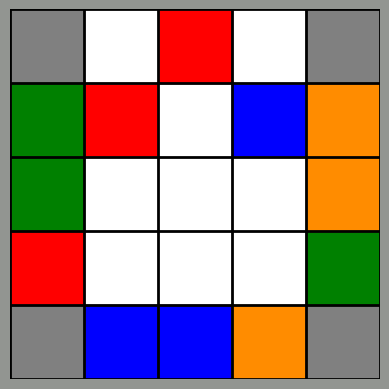

1 112
1. R U' R' U' R U2 R' U' R' D' R U2 R' D R (15)
2. S' R U R' S U R U' R' F' U F R U' R' (15)
3. R' U' R U' R' U2 R U' f R' F' R f' U' F (15)
4. R U2 R' U' R' D' R U2 R' D R U2 R U' R' (15)
5. f' F R U R' S U R U' R' F' U F R U' R' (16)
6. F U' F' U' F U' S' R U2 R' S U' F' (13)
7. F U' S' R U2 R' S U' F' U F U' F' (13)
8. f R' F' R f' U' F U2 R U2 R' U' R U' R' (15)
9. f U' f' U' f U S' R U2 R' U' F' (12)
10. R U' R' F U2 F' U' R' F U2 R2 U R2 U F' R (16)
11. R' F' U F U R U' R' U2 R U' S' R' U2 R S (16)
12. F R' U' R F' R' D U R U R' D' R F U' F' (16)
13. R' F' U F U R S' U' R' U2 R U' R' U2 R S (16)
14. F' U r' U2 R U R' U r F U R' F R F' (15)
15. R U' R' U2 f R' F' R f' U' F U2 R U2 R' (15)
16. F U' S' R U2 R' f F' U' F' U F U' F' (14)
17. F U' F' U' F U' S' R U2 R' f F' U' F' (14)
18. S' U F U F' U F U2 S R' F' R U R U' R' (16)
19. F U2 F' U2 R' U2 R U R' F U F' R F U F' (16)
20. R' U' R F' U2 F U2 f R' F' R S' U' R' U' R (16)
21. f U' S' R U2 R' S U' f' U F U' F' (13)
22. f 

In [66]:
# i -= 2 # -1 overall 
i += 1

key = subset_keys[i]
algs_ = sorted(zblls_dict[subset][key], key = lambda x: score_alg(x))
cube = Cube()
cube.apply_int_moves(invert_alg_array(algs_[0]))
fig = plot_top_layer(cube.state)
plt.show()

print(i+1, len(algs_)) 
for j, alg in enumerate(algs_):
    print(f"{j+1}. {array_to_alg(alg)} ({len(alg)})")

In [22]:

# # make a new dict with all algs in string format
zblls_dict_str = {}
for key, value in zblls_dict.items():
    zblls_dict_str[key] = {}
    for k, v in value.items():
        zblls_dict_str[key][k] = [array_to_alg(alg) for alg in v]

# make zblls_dict from zblls_dict_str
# zblls_dict = {}
# for key, value in zblls_dict_str.items():
#     zblls_dict[key] = {}
#     for k, v in value.items():
#         zblls_dict[key][k] = [alg_to_array(alg) for alg in v]

In [70]:
import json
# save zblls_dict_str using json
with open("zblls_RUFLrlfS_16.json", "w") as f:
    json.dump(zblls_dict_str, f, indent = 4)

# # load zblls_dict_str using json
# with open("zblls_dict_str.json", "r") as f: # zblls_18_RUFrfS
#     zblls_dict_str = json.load(f)

# zblls_dict = {}
# for key, value in zblls_dict_str.items():
#     zblls_dict[key] = {}
#     for k, v in value.items():
#         zblls_dict[key][k] = [alg_to_array(alg) for alg in v]

In [68]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import Table, TableStyle
from reportlab.platypus import KeepTogether
from PIL import Image as PILImage
import matplotlib.pyplot as plt
import io
import tempfile


In [69]:
def generate_image(state, colors=["grey","green","r","b","darkorange","w","y"]):
    """Generate image from cube state."""
    fig = plot_top_layer(state, colors)
    with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as tmp_file:
        fig.savefig(tmp_file, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
        print("Image saved to:", tmp_file.name)
        plt.close(fig)
        return tmp_file.name

def generate_pdf(data, name):
    """Generate PDF using reportlab."""
    doc = SimpleDocTemplate(fr"{name}.pdf", pagesize=letter)

    styles = getSampleStyleSheet()
    title_style = styles["Heading1"]
    title_style.fontSize = 18  # Increase font size for title
    title_style.alignment = 1  # Center alignment
    alg_style = styles["Normal"]
    alg_style.fontName = "Helvetica-Bold"  # Change font to bold Helvetica for algorithms
    alg_style.fontSize = 10  # Decrease font size for algorithms
    img_width = 2.0 * inch
    img_height = 2.0 * inch

    story = []

    # Add title
    title = Paragraph(name.upper(), title_style)
    story.append(title)

    k = 0
    for key, value in data.items():
        k += 1
        # Create cube state from the first array
        cube = Cube()
        cube.apply_int_moves(invert_alg_array(value[0]))

        # Add thick black border before each picture
        line = "<b>" + "-" * int(0.1 * doc.width) + " " + name + str(k) + " " + "-" * int(0.1 * doc.width) + "</b>"  # Make the line fill the page width
        para = Paragraph(line, alg_style)
        story.append(para)
        
        # Combine image and algorithms into one KeepTogether element
        img_and_algs = []
        img_and_algs.append(Image(generate_image(cube.state), width=img_width, height=img_height))
        img_and_algs.append(Spacer(1, 0.1 * inch))  # Add some space between image and algorithms
        
        # Add arrays with line numbers
        # sort value
        value = sorted(value, key = lambda x: score_alg(x))
        for i, array in enumerate(value[:12]):
            alg = f"<b>{i+1}. {array_to_alg(array)}</b>"  # Make algorithms bold
            para = Paragraph(alg, alg_style)
            img_and_algs.append(para)
        
        # Keep image and algorithms together on the same page
        img_and_algs = KeepTogether(img_and_algs)
        story.append(img_and_algs)

    doc.build(story)

for subset in ["pll", "sune", "antisune", "pi", "H", "L", "T", "U"]:
    generate_pdf(zblls_dict[subset], subset)

Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmp80dktp7v.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmp5od8atcn.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpi4q9onih.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpl8ab7o52.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmp1vkm8ruc.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpkb7ilmts.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpddnaz24s.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpcgt6vv6j.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpc46yj3ji.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpseltnrjd.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpc0ui7b3j.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpao7xfq0m.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpyv4o3yrp.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmps8zyvik1.png
Image saved to: C:\Users\ulrik\AppData\Local\Temp\tmpeqglq26c.png
Image save

In [2]:
# open test.txt and put each line in a list
with open('test.txt', 'r') as f:
    test = f.readlines()

# remove \n from each element
test = [x.strip() for x in test]
test

["R U R U R' U R' F R2 F' R2 F R2 F' R2 U2 R2",
 "B2 F2 R' D2 B2 L' B2 R D2 B' L' F2 L B' U",
 "U2 F R' F U' F2 U F2 R' B2 D2 L' D2 B2 R2 U2",
 "F2 U2 R F2 D2 B2 L' F2 U2 L' B D2 R' B R' F U",
 "F' R L2 B2 U' B2 U B2 L2 U R' B' U F U' B",
 "U2 B D2 L2 U2 F L2 D2 F2 L' B' L F2 R' U' R' U'",
 "U2 F R' F L2 B D' R2 B L2 F2 L2 B R' L2",
 "F D R2 B2 D' L2 U R F2 R F2 U' L2 F' U",
 "L F2 L B2 R B R B L2 F2 B' R2 B",
 "U2 F2 U' R2 D' B2 D R2 F2 U' L' F L' U2 L F2 L' U2",
 "F2 U2 B L' U L U F' L2 F2 L2 U2 F U2 B' U",
 "U' L2 D' B2 D' B2 D2 L2 U F' L' U' L F' U2 F2",
 "F' U2 L' B' U' B2 L' F L2 D2 F' D2 B' L2 B L2 B'",
 "L D R' D' F' L D R' D R2 D2 F2 L2 U' L2 F2 L2 U'",
 "U' R2 U2 R2 U' R2 U2 R2 F' R' U R U' F R",
 "U' B' R2 B R U2 R U B2 D' F2 D' L2 D F2 D B2",
 "U2 B' R2 B R2 F' R2 F R D' L' F L D R",
 "L2 R2 B D2 B2 D2 B R2 L' U F2 U' F L' F' U",
 "U' F' R U R2 F R U2 F2 U L2 U F2 U L2 F2 U2 L2",
 "R2 U2 F2 L2 D2 B2 L2 F2 U B2 U B F' L' U L F U' B",
 "U2 F' L' U2 L U F U F2 L2 D' B2 D' B2 D